In [190]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import Birch
%matplotlib inline

In [191]:
PATH = "../data/JPEG/" 
image = cv2.imread(PATH+'IMG_2492.jpg')

## Original Image

Tamaño original :  (4032, 3024, 3)
Tamaño reducido :  (2016, 1512, 3)


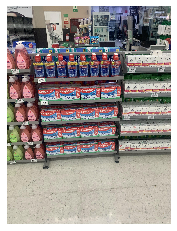

In [192]:
image = cv2.imread(PATH+'IMG_2492.jpg', cv2.IMREAD_UNCHANGED)
 
print('Tamaño original : ', image.shape)
 
scale_percent = 50 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
 
print('Tamaño reducido : ',resized_image.shape)
 
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

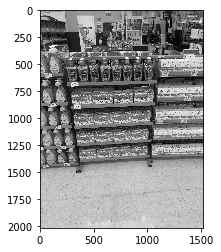

In [193]:
gray= cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
#plt.axis("off")
plt.imshow(gray, cmap='gray')
plt.show()

# Cropped Detail of interest

In [194]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

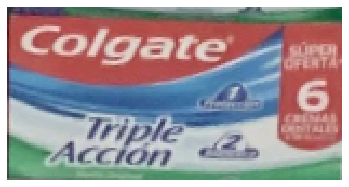

In [195]:
#Sample objective images

# cropped = rotate_image(resized_image, -6)[int(2540*scale_percent/100):int(2700*scale_percent/100), int(980*scale_percent/100):int(1290*scale_percent/100)]

# cropped = rotate_image(resized_image, -4)[int(240*scale_percent/100):int(2718*scale_percent/100), 
#                                         int(1000*scale_percent/100):int(1317*scale_percent/100)]

cropped = rotate_image(resized_image, -6)[int(2540*scale_percent/100):int(2700*scale_percent/100),                                         int(980*scale_percent/100):int(1290*scale_percent/100)]                     

# cropped = resized_image[int(2540*scale_percent/100):int(2760*scale_percent/100), int(1050*scale_percent/100):int(1360*scale_percent/100)]

# cropped = resized_image[int(1520*scale_percent/100):int(1720*scale_percent/100), int(1360*scale_percent/100):int(1700*scale_percent/100)]
# cropped = rotate_image(resized_image, -6)


plt.axis("off")
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.show()

# SIFT DETECTOR

In [196]:
def sift_detector(new_image, image_template):
    # Function that compares input image to template
    # It then returns the number of SIFT matches between them
    image1 = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    image2 = image_template

    # Create SIFT detector object
    #sift = cv2.SIFT()
    sift = cv2.SIFT_create()
    # Obtain the keypoints and descriptors using SIFT
    keypoints_1, descriptors_1 = sift.detectAndCompute(image1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image2, None)

    # Define parameters for our Flann Matcher
    FLANN_INDEX_KDTREE = 4
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
    search_params = dict(checks = 100)

    # Create the Flann Matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Obtain matches using K-Nearest Neighbor Method
    # the result 'matchs' is the number of similar matches found in both images
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)

    # Store good matches using Lowe's ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m) 
    return len(good_matches)

In [197]:
image_template = cropped
input_image = resized_image

In [198]:
height, width = image_template.shape[:2]
prob_width, prob_height = int(width*1.5), int(height*1.5)

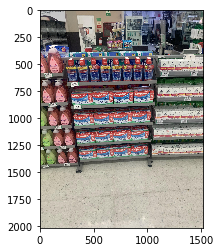

In [199]:
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.show()

79


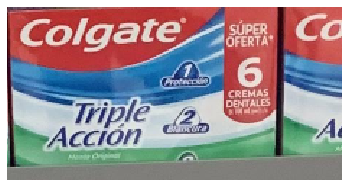

In [200]:
y, x = int(1520*scale_percent/100), int(1350*scale_percent/100)
temp_img = resized_image[y:y+prob_height, x:x+prob_width]
# temp_img = input_image[int(1520*scale_percent/100):int(1720*scale_percent/100), int(1360*scale_percent/100):int(1700*scale_percent/100)]

print(sift_detector(temp_img, image_template))
plt.axis("off")
plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
plt.show()

In [201]:
x_detect=[]
y_detect=[]
score = []
threshold = 30
counter = 0

for y in range(0, input_image.shape[0]-height, int(min(image_template.shape[:2])/3)):
    for x in range(0, input_image.shape[1]-width, int(min(image_template.shape[:2])/3)):
        temp_img = input_image[y:y+height, x:x+width]
        matches = sift_detector(temp_img, image_template)
        if matches >= threshold:
            x_detect.append(x)
            y_detect.append(y)
            score.append(matches)
            counter += 1
            #cv2.rectangle(input_image, (x, y), (x+width, y+height), (255,255,255), 1)
print(counter)

304


304


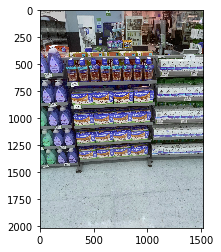

In [202]:
print(counter)
plt.imshow(input_image)
plt.show()

In [203]:
lista = np.array(list(zip(x_detect, y_detect)))

In [204]:
clustering = Birch(threshold=min(image_template.shape[:2])*0.85 , n_clusters=None).fit(lista)
print(f'El número de objetos detectados es aproximadamente: ', str(max(clustering.labels_)+1))

El número de objetos detectados es aproximadamente:  18


In [205]:
centroids = []
for each in np.unique(clustering.labels_):
    centroids.append(lista[clustering.labels_ == each].sum(axis=0)/len(lista[clustering.labels_ == each]))

In [206]:
for x, y in centroids:
    x = int(x)
    y = int(y)
    cv2.rectangle(input_image, (x, y), (x+width, y+height), (0,255,0), 3)

18


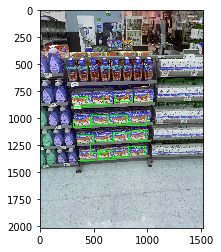

In [207]:
print(len(centroids))
plt.imshow(input_image)
plt.show()
cv2.imwrite('SIFT_DETECTION.jpg', input_image);